In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

In [70]:
from models.components import sasrec, bert4rec, bsarec

In [ ]:
checkpoint_dir = # Put the checkpoint in src/data here

In [72]:
def ckpt(name: str):
    '''
    The code is model_data_treatment
    model: sasrec, bert4rec, bsarec
    data: last, beauty, ml, yelp
    treatment: null, o, z
    '''
    return f'{checkpoint_dir}/{name}'

In [74]:
from collections import OrderedDict
#torch.load(directory, map_location=lambda storage, loc: storage)

def new_dict(state_dict):
    new_state_dict = OrderedDict()

    for k, v in state_dict['state_dict'].items():
        if k[:4] == 'net.':
            name = k[4:]  # remove `net.`
        else:
            name = k
        new_state_dict[name] = v
    return new_state_dict

In [75]:
def state_dict(name:str):
    path_name = ckpt(name)
    try:
        state_dict = torch.load(path_name, map_location=torch.device('cpu'))
        item_size = state_dict['datamodule_hyper_parameters']['others']['item_size']
        new_state_dict = new_dict(state_dict)
        return new_state_dict, item_size
    except:
        print(f'No checkpoint yet')

In [77]:
class transformer_class_sasrec: # initialization
    def __init__(self):
        pass
    hidden_size = 64 # need to be called again
    hidden_dropout_prob =  0.1 # this too
    num_attention_heads = 2
    num_hidden_layers = 2
    attention_probs_dropout_prob= 0.5
    hidden_act= 'gelu'

class transformer_class_bert4: #initialization
    def __init__(self):
        pass
    mask_ratio = 0.2
    hidden_size = 64 # need to be called again
    hidden_dropout_prob =  0.1 # this too
    num_attention_heads = 2
    num_hidden_layers = 2
    attention_probs_dropout_prob= 0.5
    hidden_act= 'gelu'

class transformer_class_bsarec:
    def __init__(self):
        pass    
    hidden_size= 64 # need to be called again
    hidden_dropout_prob= 0.1 # this too
    num_attention_heads= 4
    num_hidden_layers= 2
    attention_probs_dropout_prob= 0.5
    hidden_act= 'gelu'
    c = 3 # this hyperparameter is default from the original code
    alpha = 0.9 # this too.


# class instantiation
transformer_class_sasrec = transformer_class_sasrec()
transformer_class_bert4 = transformer_class_bert4()
transformer_class_bsarec = transformer_class_bsarec()

In [78]:
def model(name:str):
    state_dict_, item_size = state_dict(name)
    if name[:6] == 'sasreq':
        model = sasrec.SASRecModel(
        hidden_dropout_prob= 0.1,
        item_size= item_size,
        hidden_size= 64,
        max_seq_length= 50,
        initializer_range= 0.02,
        transformer= transformer_class_sasrec
        )
    elif name[:8] == 'bert4rec':
        model = bert4rec.BERT4RecModel(
        mask_ratio= 0.2,
        hidden_dropout_prob= 0.1,
        item_size= item_size,
        hidden_size= 64,
        max_seq_length= 50,
        initializer_range= 0.02,
        transformer= transformer_class_bert4
        )
    elif name[:6] == 'bsarec':
        model = bsarec.BSARecModel(
        hidden_dropout_prob= 0.1,
        item_size= item_size,
        hidden_size= 64,
        max_seq_length= 50,
        initializer_range= 0.02,
        transformer= transformer_class_bsarec
        )

    model.load_state_dict(state_dict_)
    return model

In [ ]:

bsarec_last_z = model('bsarec_last_z')
bsarec_beauty_z = model('bsarec_beauty_z')
bsarec_ml_z = model('bsarec_ml_z')
bsarec_yelp_z = model('bsarec_yelp_z')

# BSARec vanilla
bsarec_last = model('bsarec_last')
bsarec_beauty = model('bsarec_beauty')
bsarec_ml = model('bsarec_ml')
bsarec_yelp = model('bsarec_yelp')


In [83]:
norm_beta = lambda module: module.item_encoder.blocks[0].layer.filter_layer.sqrt_beta.detach().cpu().norm().numpy()

In [152]:
random_bsarec_list = [bsarec_last, bsarec_ml, bsarec_beauty, bsarec_yelp]
random_bsarec_list_z = [bsarec_last_z, bsarec_ml_z, bsarec_beauty_z, bsarec_yelp_z]

In [153]:
# mapping
norm_beta_list = list(map(norm_beta, random_bsarec_list))
norm_beta_list_z = list(map(norm_beta, random_bsarec_list_z))

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/dv/789rlrv9705cb4xh_x3cvnhw0000gn/T/ipykernel_49280/1372707784.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Norm of $\\sqrt{\mathbf{\\beta}}$', fontsize=25)


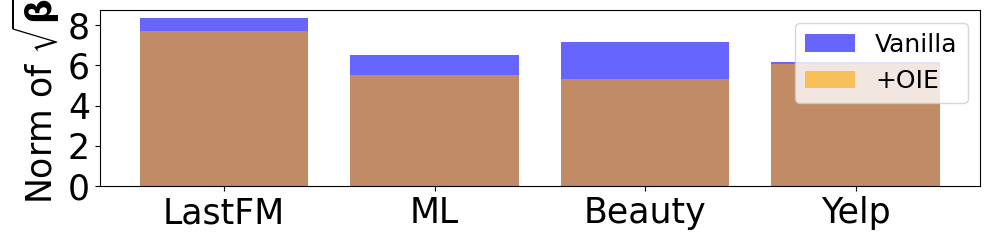

In [157]:
# plotting as bar chart
plt.figure(figsize=(10, 2.5))
plt.bar(range(len(norm_beta_list)), norm_beta_list, color='blue', alpha=0.6, label='Vanilla')
plt.bar(range(len(norm_beta_list_z)), norm_beta_list_z, color='orange', alpha=0.6, label='+OIE')
plt.xticks(range(len(norm_beta_list)), ['LastFM', 'ML', 'Beauty', 'Yelp'])
# plt.xlabel('Dataset')
plt.ylabel('Norm of $\\sqrt{\mathbf{\\beta}}$', fontsize=25)
# plt.title('Norm of Beta for BSARec and BSARec+')
plt.legend(fontsize=18)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig('fig6.pdf', dpi=450, bbox_inches='tight')